# Trabajo Práctico: Predicción de precios de casas

Integrantes:
Zahradnicek Ezequiel
Herrera Francisca


# Contexto del problema

El dataset con el que vamos a trabajar se llama house-prices.csv y contiene información de precios de casas de Boston, y otras variables características que se detallan a continuación.

Características de entrada en orden:

1) CRIM: tasa de criminalidad per cápita por ciudad

2) ZN: proporción de terrenos residenciales zonificados para lotes de más de 25,000 pies cuadrados

3) INDUS: proporción de acres de negocios no minoristas por ciudad

4) CHAS: variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)

5) NOX: concentración de óxidos de nitrógeno (partes por 10 millones) [parts/10M]

6) RM: número promedio de habitaciones por vivienda

7) AGE: proporción de unidades ocupadas por sus propietarios construidas antes de 1940

8) DIS: distancias ponderadas a cinco centros de empleo de Boston

9) RAD: índice de accesibilidad a las autopistas radiales

10) TAX: tasa de impuesto sobre la propiedad a valor completo por $10,000 [$/10k]

11) PTRATIO: proporción alumno-maestro por ciudad

12) B: El resultado de la ecuación B=1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad

13) LSTAT: % de población de menor estatus socioeconómico

La variable de salida o target, que vamos a querer predecir, es la siguiente.

MEDV: Valor mediano de las viviendas ocupadas por sus propietarios en miles de dólares [k$]


# Importación de Librerías

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, SGDRegressor

In [109]:
#import warnings
#warnings.filterwarnings("ignore")

# Analisis exploratorio

In [110]:
df = pd.read_csv('house-prices-tp.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     533 non-null    float64
 1   ZN       534 non-null    float64
 2   INDUS    541 non-null    float64
 3   CHAS     533 non-null    float64
 4   NOX      532 non-null    float64
 5   RM       535 non-null    float64
 6   AGE      532 non-null    float64
 7   DIS      541 non-null    float64
 8   RAD      528 non-null    float64
 9   TAX      538 non-null    float64
 10  PTRATIO  528 non-null    float64
 11  B        534 non-null    float64
 12  LSTAT    534 non-null    float64
 13  MEDV     535 non-null    float64
dtypes: float64(14)
memory usage: 60.9 KB


In [112]:
# Se comprueba la cantidad de nulos
df.isnull().sum()

,0
CRIM,23
ZN,22
INDUS,15
CHAS,23
NOX,24
RM,21
AGE,24
DIS,15
RAD,28
TAX,18


Contamos con 556 registros, de tipo float64. Se encuentran valores faltantes.

In [113]:
# Eliminamos los registros donde hay faltantes en la columna target (21 filas).
df.dropna(subset=['MEDV'], inplace=True)
df['MEDV'].isnull().sum()

0

In [114]:
# Exploramos el rango de nuestras variables
summary = df.describe()
print(summary)

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  524.000000  524.000000  531.000000  526.000000  526.000000  528.000000   
mean     4.986916   12.502639   11.226209    0.085551    0.558494    6.276490   
std     11.942453   24.285730    6.924961    0.279967    0.118563    0.753687   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.083545    0.000000    5.130000    0.000000    0.453000    5.875750   
50%      0.290250    0.000000    9.690000    0.000000    0.538000    6.198500   
75%      4.545407   20.000000   18.100000    0.000000    0.631000    6.630250   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  524.000000  530.000000  523.000000  526.000000  526.000000  526.000000   
mean    67.655714    3.894992    9.624208  409.190733   18.422678  350.869333   
std     28.566043    2.2056

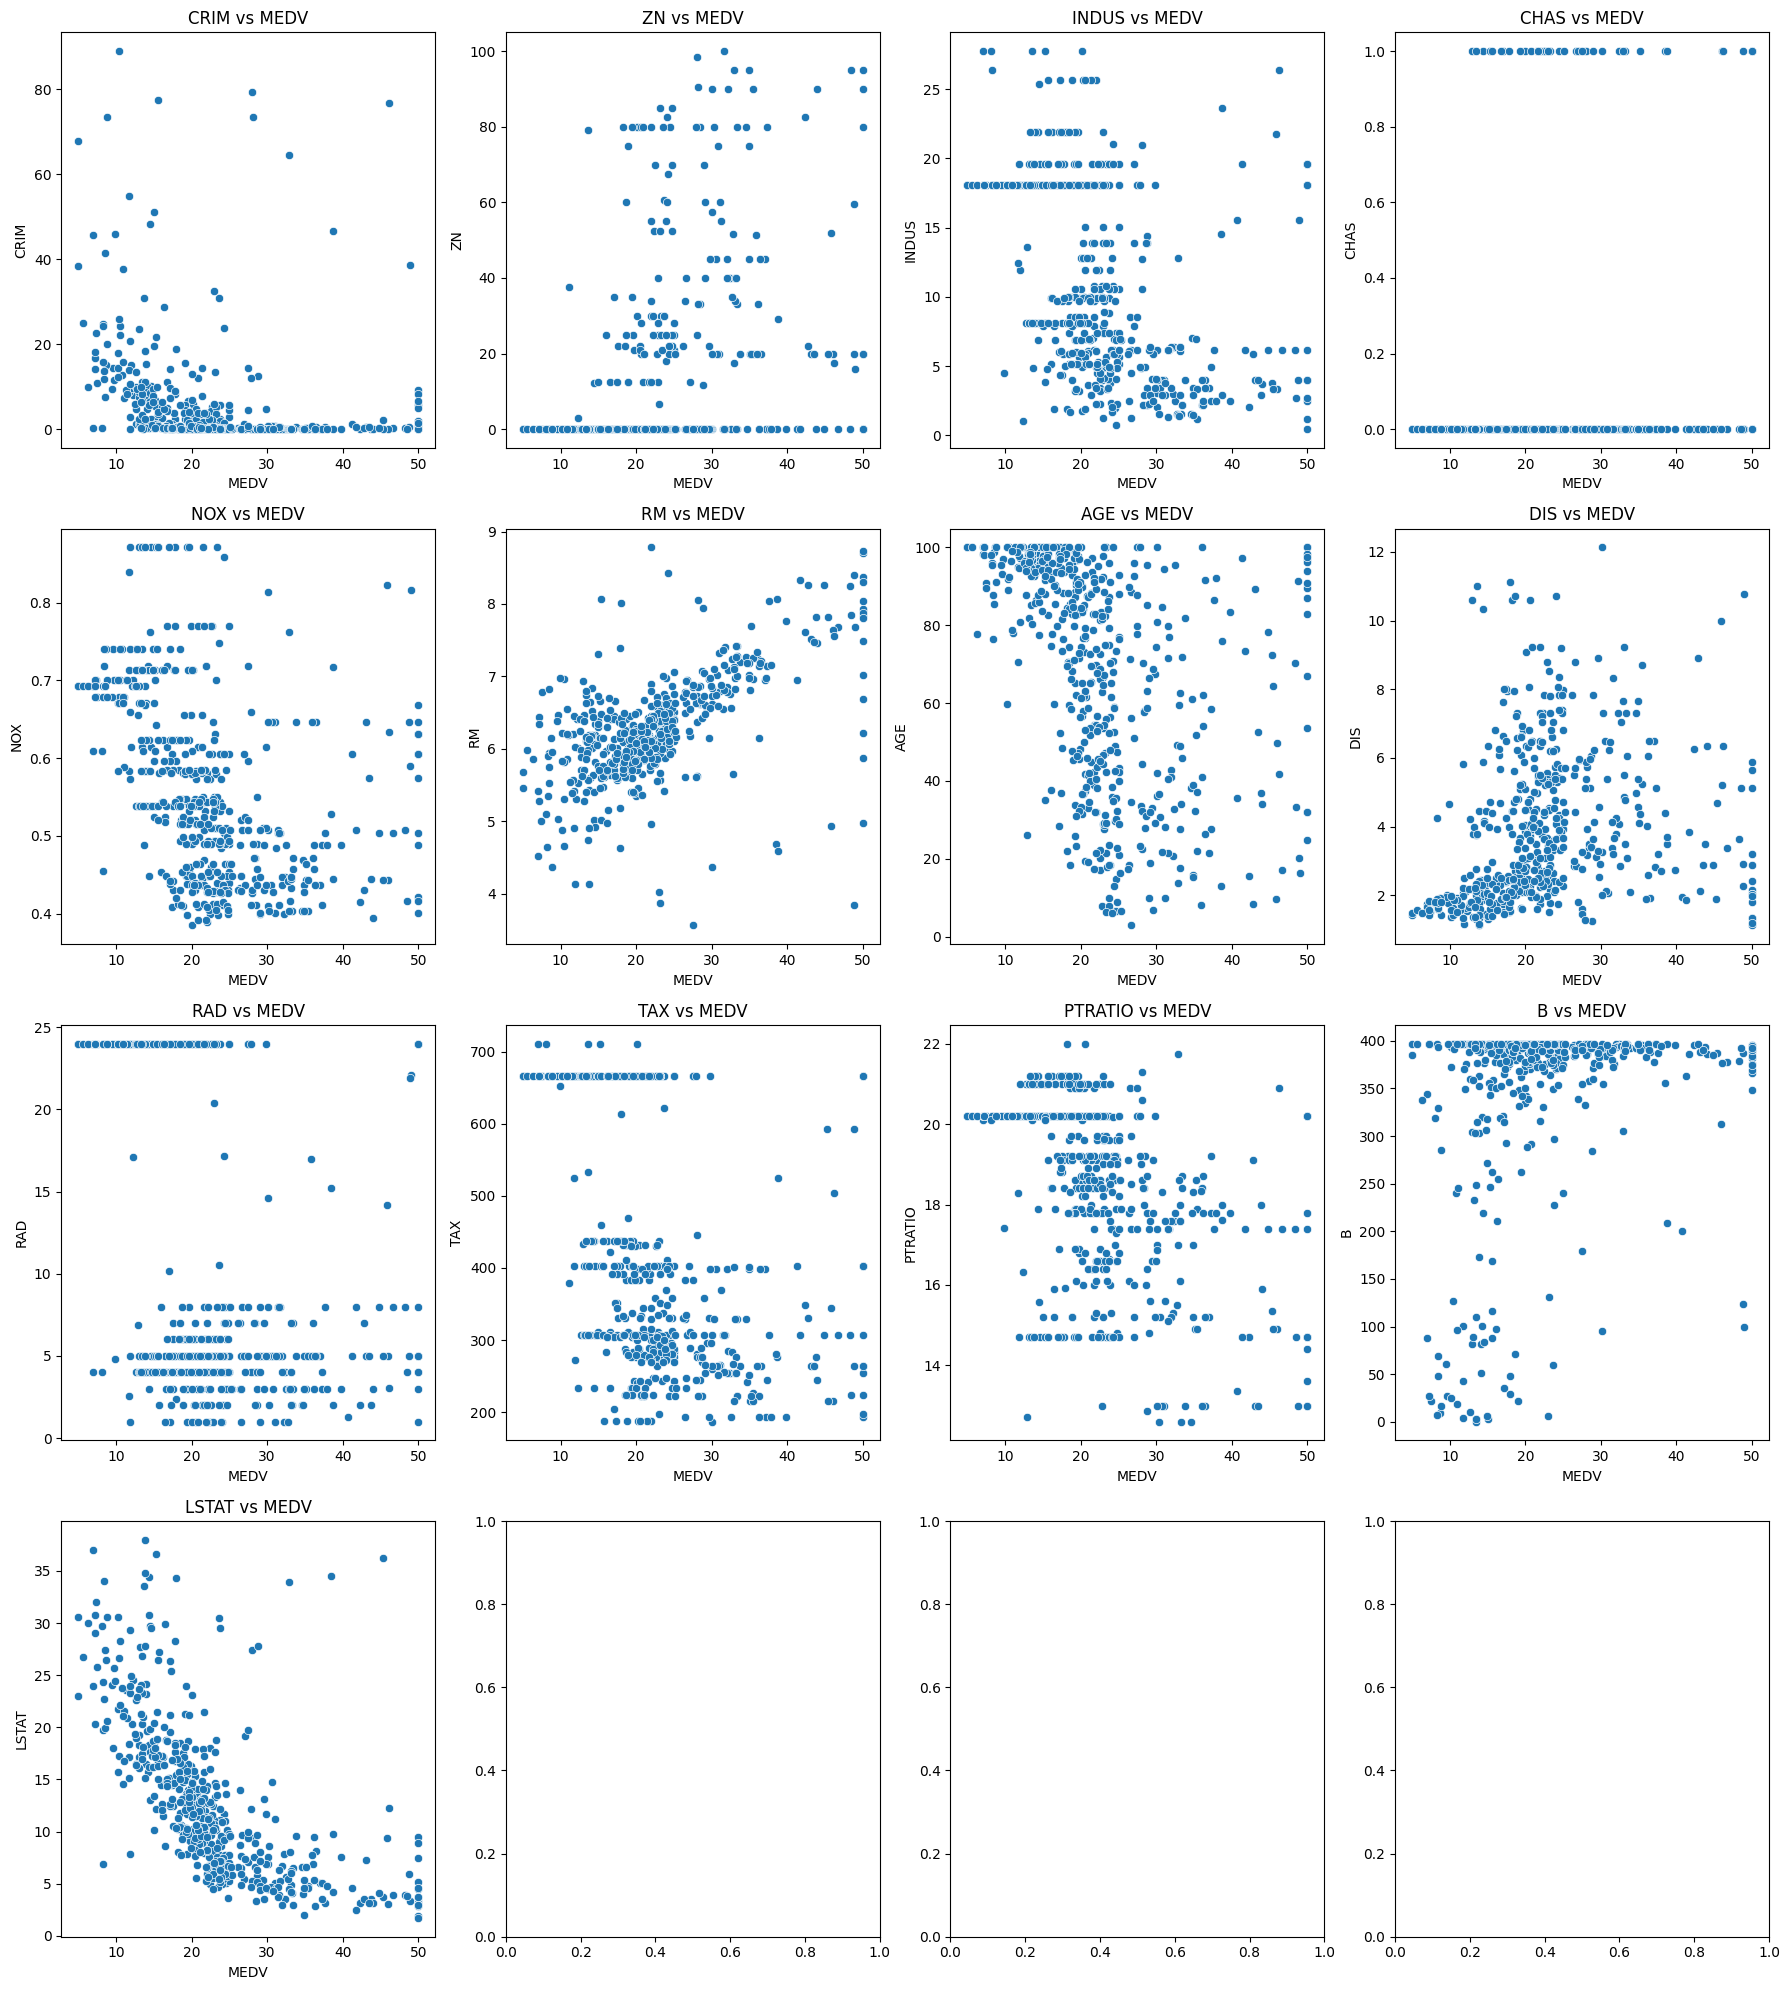

In [115]:
# Creamos scatterplots para cada variable en relación con 'MEDV'
target = 'MEDV'
features = [col for col in df.columns if col != target]

# Configurar la figura y los ejes
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.scatterplot(x=df[target], y=df[feature], ax=axes[i])
    axes[i].set_title(f'{feature} vs {target}')

# Ajustar los espacios entre gráficos
plt.tight_layout()
plt.show()

Se observa una aparente relación lineal entre RM (número promedio de habitaciones por vivienda) y la variable objetivo, así como una posible cuadrática entre LSTAT (% de población de menor estatus socioeconómico) y la variable objetivo.

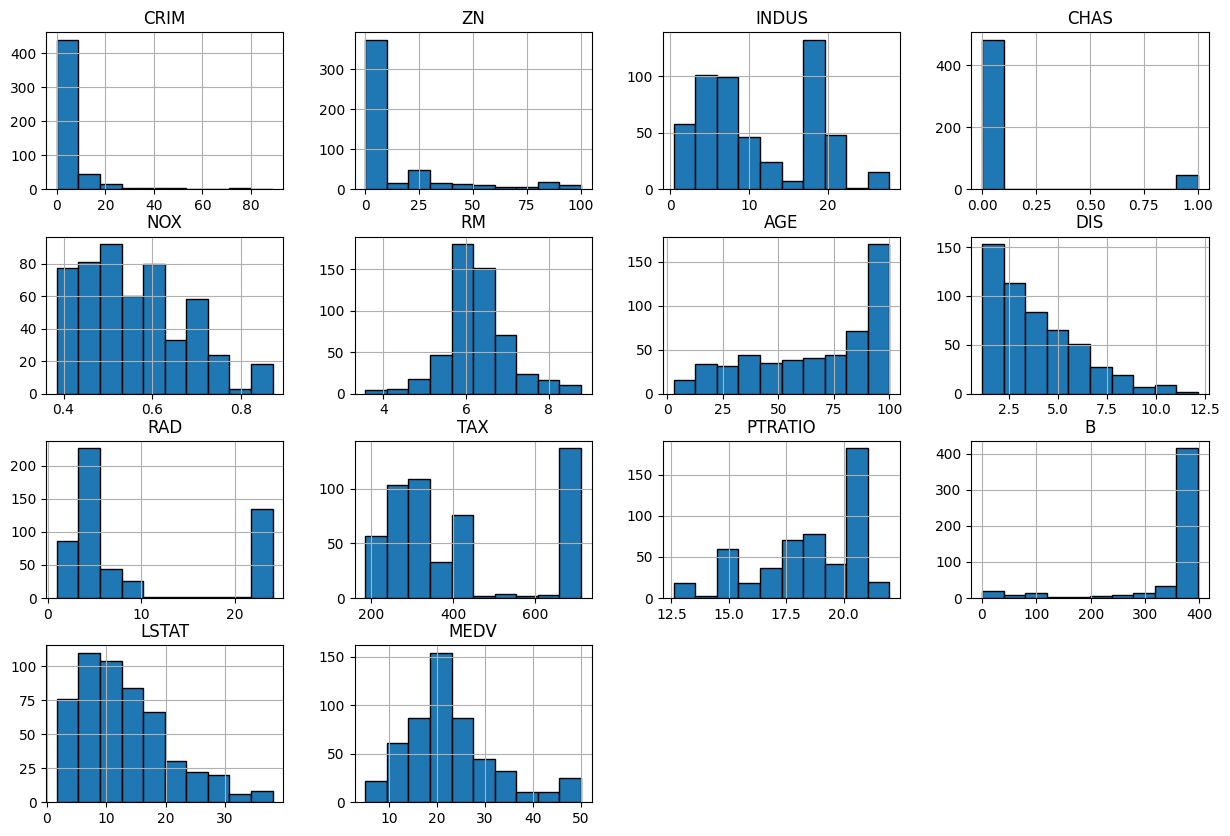

In [116]:
df.hist(figsize=(15,10), edgecolor='black')
plt.show()

Consideraciones:
1. **CRIM**: La mayoría de los valores de criminalidad están muy concentrados cerca del cero, con algunos valores que llegan hasta 80.
2. **ZN**: La mayoría de los terrenos residenciales tienen valores bajos, concentrados en 0, con algunos casos que llegan a 100.
3. **INDUS**: La distribución está bastante dispersa entre 0 y 25, mostrando varios picos en diferentes puntos.
4. **CHAS**: La mayoría de los puntos indican que las propiedades no están cerca del río (valor 0), con muy pocos valores en 1.
5. **NOX**: La concentración de óxidos de nitrógeno muestra una distribución sesgada hacia la derecha, con la mayoría de los valores entre 0.4 y 0.6.
6. **RM**: El número promedio de habitaciones sigue una distribución aproximadamente normal, centrada alrededor de 6.
7. **AGE**: La mayoría de las propiedades tienen una antigüedad superior al 75%, con una tendencia creciente hacia valores más altos.
8. **DIS**: La distancia a los centros de empleo muestra una tendencia decreciente, con la mayoría de las propiedades situadas a menos de 5 unidades.
9. **RAD**: Hay una gran concentración de valores bajos en el índice de accesibilidad radial.
10. **TAX**: Los valores de impuestos se agrupan en torno a algunos puntos clave, especialmente alrededor de 300 y 700.
11. **PTRATIO**: La distribución de la proporción de estudiantes por maestro muestra una concentración alta en torno al valor 20.
12. **B**: La mayoría de los valores del coeficiente relacionado con la población afroamericana están cerca de 400, aunque hay varios valores bajos.
13. **LSTAT**: El porcentaje de población de menor estatus socioeconómico sigue una distribución sesgada hacia la izquierda, con más frecuencia de valores bajos.
14. **MEDV**: La variable objetivo muestra una distribución aproximadamente normal, con un pico alrededor de 20-25.

<Axes: >

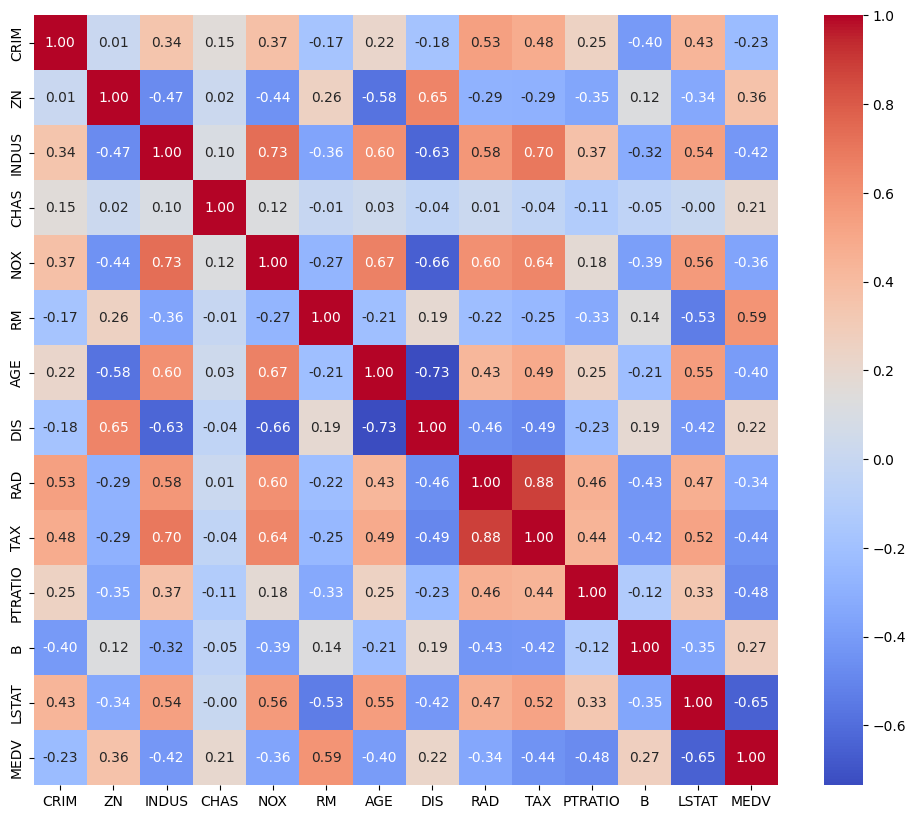

In [117]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')

Se encuentra una correlación muy alta entre TAX y RAD (lo que a simple vista indica que la tasa de impuesto sobre la propiedad está relacionada con el índice de accesibilidad a las autopistas radiales). Además, se ve una correlación moderada entre las siguientes variables:

*   INDUS y NOX: La proporción de negocios se relaciona con la concentración de óxidos de nitrógeno.
*   DIS y AGE: Las distancias a centros de empleo se relacionan con la proporción de unidades ocupadas.

## Primer análisis de outliers

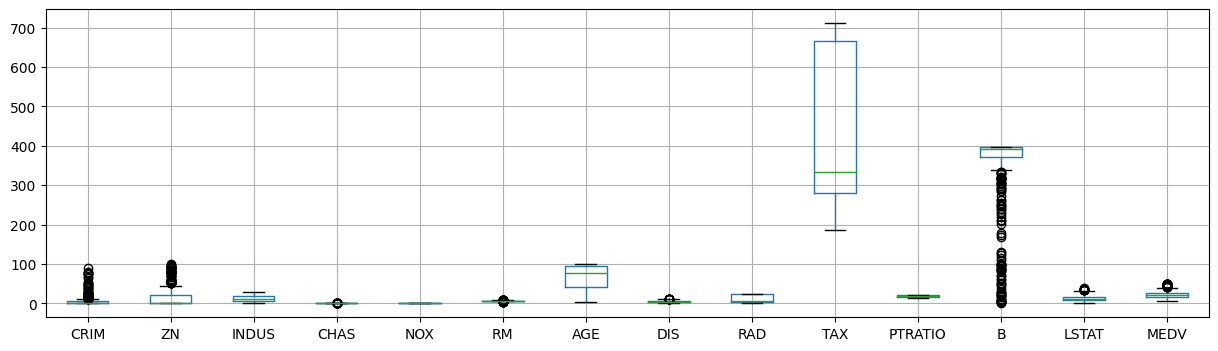

In [118]:
df.boxplot(figsize=(15,4))
plt.show()

In [119]:
def val_atipicos(data, columnas):
    resultados = {}
    sin_atipicos = []
    con_atipicos = []

    for col in columnas:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        at_min = Q1 - 1.5 * IQR
        at_max = Q3 + 1.5 * IQR

        # Filtramos valores atípicos
        outliers_low = data[data[col] < at_min]
        outliers_high = data[data[col] > at_max]

        # Guardamos resultados
        if not outliers_low.empty or not outliers_high.empty:
            resultados[col] = {
                'Límite inferior': at_min,
                'Límite superior': at_max,
                'Cant. valores atípicos (inferiores)': outliers_low.shape[0],
                'Cant. valores atípicos (superiores)': outliers_high.shape[0]
            }
            con_atipicos.append((col, resultados[col]['Cant. valores atípicos (inferiores)'] + resultados[col]['Cant. valores atípicos (superiores)']))
        else:
            sin_atipicos.append(col)

    # Ordenamos columnas con atípicos por la cantidad de valores atípicos
    con_atipicos.sort(key=lambda x: x[1])

    # Resultado final
    resultado_ordenado = {}
    for col in sin_atipicos:
        resultado_ordenado[col] = 'No hay valores atípicos'
    for col, _ in con_atipicos:
        resultado_ordenado[col] = resultados[col]

    return resultado_ordenado

In [120]:
columnas = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'] #CHAS: Var. Binaria Exluída
resultados = val_atipicos(df, columnas)

for col, info in resultados.items():
    print(f'Columna: {col}')
    if isinstance(info, dict):
        for key, value in info.items():
            print(f'{key}: {value}')
    else:
        print(info)
    print()

Columna: INDUS
No hay valores atípicos

Columna: NOX
No hay valores atípicos

Columna: AGE
No hay valores atípicos

Columna: RAD
No hay valores atípicos

Columna: TAX
No hay valores atípicos

Columna: PTRATIO
No hay valores atípicos

Columna: DIS
Límite inferior: -2.661825
Límite superior: 10.056775
Cant. valores atípicos (inferiores): 0
Cant. valores atípicos (superiores): 10

Columna: LSTAT
Límite inferior: -7.923749999999998
Límite superior: 32.20625
Cant. valores atípicos (inferiores): 0
Cant. valores atípicos (superiores): 11

Columna: MEDV
Límite inferior: 2.4250000000000043
Límite superior: 40.62499999999999
Cant. valores atípicos (inferiores): 0
Cant. valores atípicos (superiores): 37

Columna: RM
Límite inferior: 4.744
Límite superior: 7.7620000000000005
Cant. valores atípicos (inferiores): 14
Cant. valores atípicos (superiores): 27

Columna: ZN
Límite inferior: -30.0
Límite superior: 50.0
Cant. valores atípicos (inferiores): 0
Cant. valores atípicos (superiores): 55

Columna:

Se opta por emplear el escalado robusto debido a la presencia de valores atípicos.

# Regresión lineal múltiple para la predicción de la variable objetivo

## Partición del Dataframe e imputación de datos faltantes

In [121]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

# División inicial 80% para entrenamiento y 20% para testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((428, 13), (107, 13), (428,), (107,))

In [123]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)

CHAS es una variable categórica (0 o 1) que indica si una observación está cerca del río Charles.

La imputación de faltantes en la columna CHAS por la moda resulta adecuada en este caso, ya que la moda representa el valor más frecuente y es el que mejor mantiene la naturaleza de la variable.

In [124]:
# Imputer para la moda
mode_imputer = SimpleImputer(strategy='most_frequent')

X_train[['CHAS']] = mode_imputer.fit_transform(X_train[['CHAS']])
X_test[['CHAS']] = mode_imputer.transform(X_test[['CHAS']])

Se decide resolver la imputación de valores faltantes con la mediana porque es una medida robusta que minimiza la influencia de valores atípicos y es más representativa en el caso de distribuciones asimétricas.

In [125]:
# Imputer para la mediana
median_imputer = SimpleImputer(strategy='median')

X_train = median_imputer.fit_transform(X_train)
X_test = median_imputer.transform(X_test)

Se decidió aplicar la transformación Yeo-Johnson para normalizar las distribuciones de las variables y mitigar la influencia de asimetrías, mientras que el escalado robusto se eligió para manejar valores atípicos, asegurando que el modelo no se vea afectado por ellos y mejorando la estabilidad de los resultados.

In [126]:
power_transformer = PowerTransformer(method='yeo-johnson')
scaler = RobustScaler()

X_train = power_transformer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_test = power_transformer.transform(X_test)
X_test = scaler.transform(X_test)

## Método LinearRegression


In [127]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [128]:
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R^2: {test_r2}")

Train MSE: 28.01494701238633
Train RMSE: 5.292914793607236
Test MSE: 48.4170305157479
Test RMSE: 6.958234726979818
Test R^2: 0.41786687510082143


El valor de R2 de 0.42 indica que el modelo de regresión lineal explica alrededor del 42% de la variabilidad en la variable de respuesta. Esto significa que el modelo no está capturando bien las relaciones en los datos, y hay un 58% de la variabilidad que no es explicada por el modelo.

In [129]:
model.intercept_

20.68529420567727

In [130]:
coeficientes=pd.DataFrame(data=model.coef_.T, index=X.columns, columns=['coeficiente'])
print(coeficientes.sort_values(by='coeficiente', ascending=False))

         coeficiente
CRIM        3.620567
RM          2.043066
CHAS        1.412561
ZN          1.292004
RAD         0.468746
B           0.323668
INDUS       0.082841
AGE        -2.311230
PTRATIO    -2.608491
TAX        -3.640429
NOX        -3.859822
DIS        -6.562816
LSTAT      -7.397415


Se observa que las variables CRIM, LSTAT y DIS son las variables que mayor peso tienen en el modelo.

## Método de gradiente descendiente

In [131]:
def gradiente_descendente(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    model = SGDRegressor(learning_rate='adaptive', penalty=None, eta0=lr, max_iter=epochs, shuffle=False)

    train_errors = []
    test_errors = []
    test_r2_errors = []

    for epoch in range(epochs):

      model.partial_fit(X_train, y_train)

      train_pred = model.predict(X_train)
      test_pred = model.predict(X_test)

      train_mse = mean_squared_error(y_train, train_pred)
      test_mse = mean_squared_error(y_test, test_pred)
      test_r2 = r2_score(y_test, test_pred)

      test_r2_errors.append(test_r2)
      train_errors.append(train_mse)
      test_errors.append(test_mse)

    plt.figure(figsize=(15, 8))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Epoch')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs Epoch')
    plt.show()

    # Errores
    mean_train_error = np.mean(train_errors)
    mean_test_error = np.mean(test_errors)
    mean_r2 = np.mean(test_r2_errors)

    return {
        'Train Error': mean_train_error,
        'Test Error': mean_test_error,
        'R^2': mean_r2
    }

In [132]:
def mini_batch(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=5):

    model = SGDRegressor(learning_rate='constant', penalty=None, eta0=lr, max_iter=epochs, shuffle=True)

    train_errors = []
    test_errors = []
    test_r2_errors = []

    for epoch in range(epochs):

      # permutation = np.random.permutation(len(X_train))
      # X_train = X_train[permutation]
      # y_train = y_train[permutation]

      for j in range(0, len(X_train), batch_size):

          X_batch = X_train[j:j + batch_size]
          y_batch = y_train[j:j + batch_size]

          model.partial_fit(X_batch, y_batch)

          train_pred = model.predict(X_train)
          test_pred = model.predict(X_test)

          train_mse = mean_squared_error(y_train, train_pred)
          test_mse = mean_squared_error(y_test, test_pred)
          test_r2 = r2_score(y_test, test_pred)

          test_r2_errors.append(test_r2)
          train_errors.append(train_mse)
          test_errors.append(test_mse)

    plt.figure(figsize=(15, 8))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('iteraciones')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones')
    plt.show()

    # Errores
    mean_train_error = np.mean(train_errors)
    mean_test_error = np.mean(test_errors)
    mean_r2 = np.mean(test_r2_errors)

    return {
        'Train Error': mean_train_error,
        'Test Error': mean_test_error,
        'R^2': mean_r2
    }

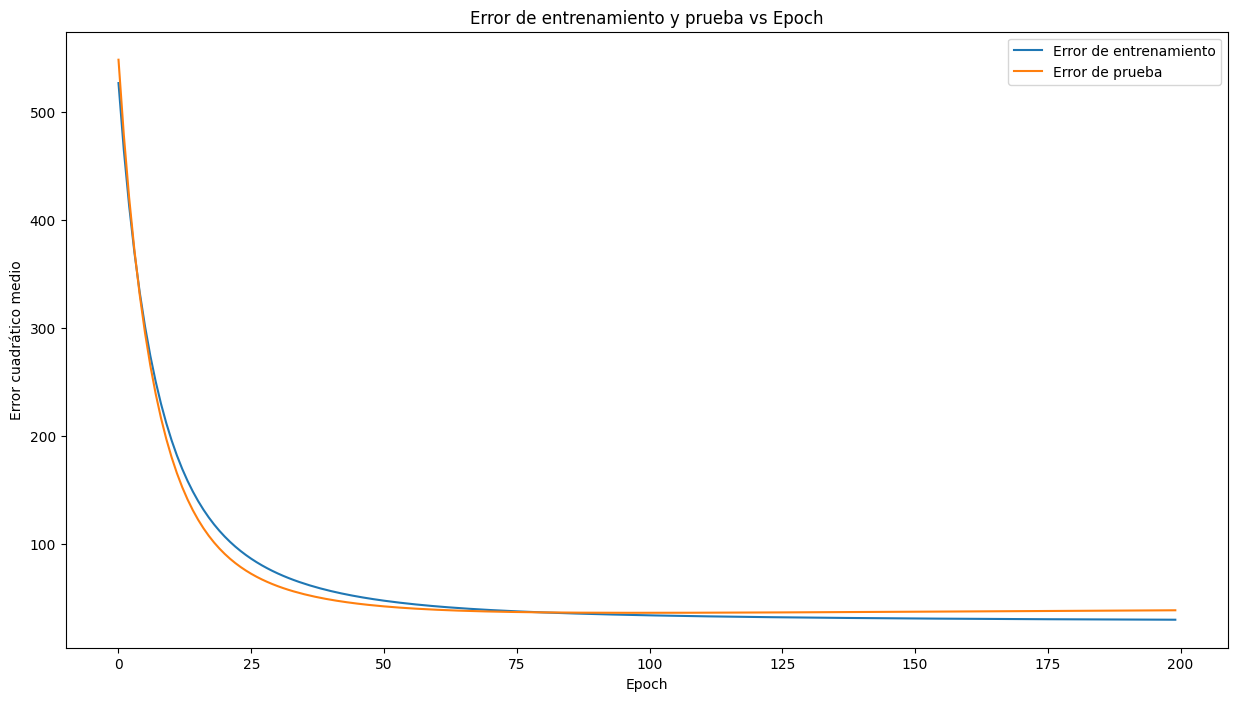

{'Train Error': 59.591676182950685,
 'Test Error': 59.902846555106144,
 'R^2': 0.2797693108391312}

In [133]:
gradiente_descendente(X_train, y_train, X_test, y_test, lr=0.0001, epochs=200)

Se observa que el valor de épocas que minimiza el error de test está cerca de 70-75.

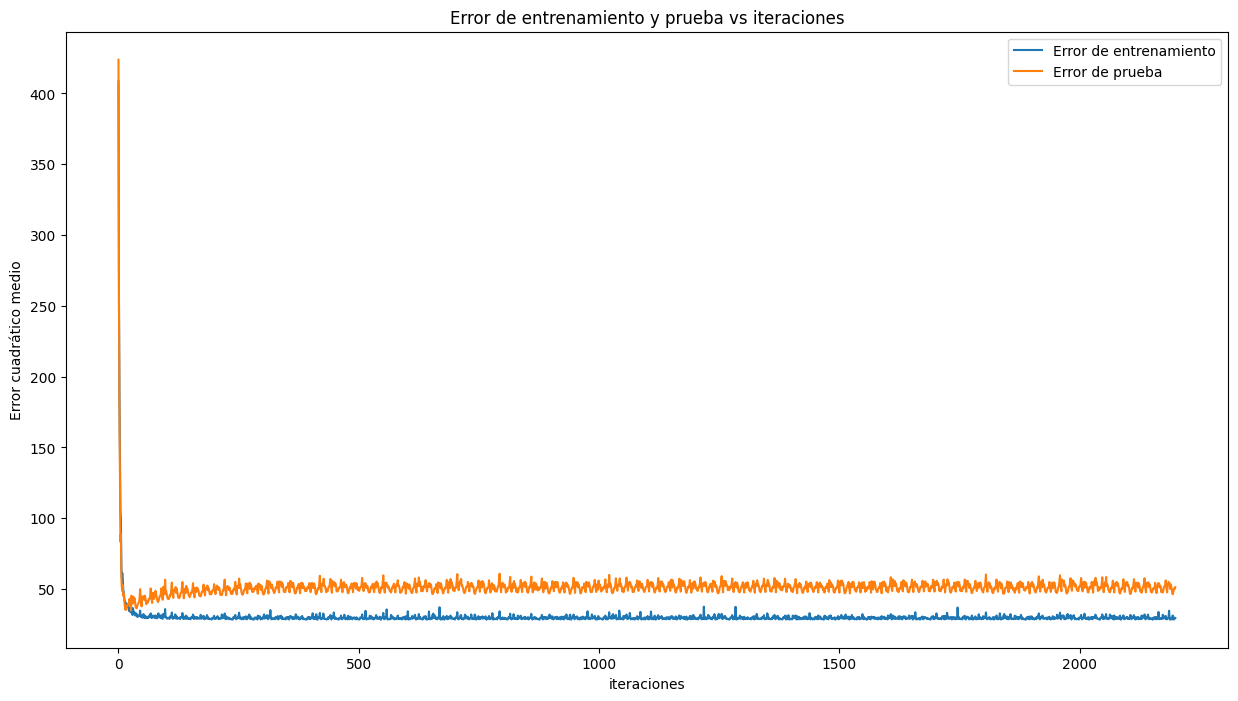

{'Train Error': 30.25727710582804,
 'Test Error': 51.332253868897986,
 'R^2': 0.3828162315096921}

In [134]:
batch = int(np.sqrt(len(X_train)))
mini_batch(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=batch)

Se observa una leve mejoría pero aún el modelo sigue sin generar buenos resultados.

## Métodos de regularización (Lasso, Ridge, Elastic Net)


In [135]:
def metrics(model):

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  r2_train = r2_score(y_train, y_train_pred)
  mse_train = mean_squared_error(y_train, y_train_pred)
  mae_train = mean_absolute_error(y_train, y_train_pred)

  r2_test = r2_score(y_test, y_test_pred)
  mse_test = mean_squared_error(y_test, y_test_pred)
  mae_test = mean_absolute_error(y_test, y_test_pred)

  return r2_train, mse_train, mae_train, r2_test, mse_test, mae_test

In [136]:
# Crear modelos de regresión lineal, Lasso y Ridge
lr = LinearRegression()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=10)
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5)

# Ajustar modelos
lr.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.01)

In [137]:
for i in [lr, lasso, ridge, elasticnet]:

  print(f'{i}:')

  r2_train, mse_train, mae_train, r2_test, mse_test, mae_test = metrics(i)

  print('\nError de train: \n')

  print(f'    MSE: {mse_train}')
  print(f'    MAE: {mae_train}')
  print(f'    R^2: {r2_train}')

  print('\nError de test: \n')

  print(f'    MSE: {mse_test}')
  print(f'    MAE: {mae_test}')
  print(f'    R^2: {r2_test}\n')

LinearRegression():

Error de train: 

    MSE: 28.01494701238633
    MAE: 3.699053589852215
    R^2: 0.6937088383807484

Error de test: 

    MSE: 48.4170305157479
    MAE: 4.359787304691121
    R^2: 0.41786687510082143

Lasso(alpha=0.1):

Error de train: 

    MSE: 29.19971372522199
    MAE: 3.7159484801965217
    R^2: 0.680755625491864

Error de test: 

    MSE: 42.71480328561279
    MAE: 4.139654109788801
    R^2: 0.4864265393554079

Ridge(alpha=10):

Error de train: 

    MSE: 28.541246234752588
    MAE: 3.675999175510976
    R^2: 0.6879547386101296

Error de test: 

    MSE: 43.07996588340986
    MAE: 4.131982056758155
    R^2: 0.48203607505209267

ElasticNet(alpha=0.01):

Error de train: 

    MSE: 28.078060991788895
    MAE: 3.6768157574026024
    R^2: 0.6930188048048477

Error de test: 

    MSE: 46.42236248032167
    MAE: 4.272160804240312
    R^2: 0.44184939373590193




*  Todos los modelos presentan un rendimiento significativamente mejor en el conjunto de entrenamiento que en el de prueba, lo que sugiere un posible sobreajuste.
*  Lasso y Ridge parecen ser los que mejor generalizan entre los modelos probados.





En cuanto a métricas, nos enfocaremos en las siguientes:

R²: Indica la proporción de la varianza de la variable objetivo (precios de viviendas) que es explicada por el modelo. Un valor cercano a 1 sugiere un buen ajuste.

MAE (Mean Absolute Error): Proporciona una medida de la precisión del modelo en términos de unidades originales, siendo menos sensible a valores atípicos que el MSE. Es útil para tener una idea clara de cuánto se desvían las predicciones en promedio.

Evaluamos el rendimiento en el conjunto de entrenamiento para identificar si el modelo se ajusta demasiado a esos datos, lo que podría resultar en un mal desempeño en datos no vistos. Las métricas del conjunto de prueba muestran cómo se comportará el modelo en datos nuevos, siendo fundamentales para evaluar su capacidad de generalización. Comparar las métricas entre entrenamiento y prueba ayuda a determinar si hay un equilibrio adecuado entre la complejidad del modelo y su capacidad de ajuste.

Hasta el momento, no hemos obtenido un buen fitting con ninguno de los modelos explorados.

## Optimización de hiperparámetros de Lasso, Ridge y Elastic Net


In [138]:
lasso_cv = LassoCV()
ridge_cv = RidgeCV()
elasticnet_cv = ElasticNetCV()

alphas_lasso = np.logspace(-6, 6, 200)
alphas_ridge = np.logspace(-6, 6, 200)
alphas_elasticnet = np.logspace(-6, 6, 200)

lasso_cv = LassoCV(alphas=alphas_lasso, cv=5)  # 5-fold cross-validation
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)  # 5-fold cross-validation
elasticnet_cv = ElasticNetCV(alphas=alphas_elasticnet, cv=5)

lasso_cv.fit(X_train, y_train)
ridge_cv.fit(X_train, y_train)
elasticnet_cv.fit(X_train,y_train)

ElasticNetCV(alphas=array([1.00000000e-06, 1.14895100e-06, 1.32008840e-06, 1.51671689e-06,
       1.74263339e-06, 2.00220037e-06, 2.30043012e-06, 2.64308149e-06,
       3.03677112e-06, 3.48910121e-06, 4.00880633e-06, 4.60592204e-06,
       5.29197874e-06, 6.08022426e-06, 6.98587975e-06, 8.02643352e-06,
       9.22197882e-06, 1.05956018e-05, 1.21738273e-05, 1.39871310e-05,
       1.60705282e-05, 1.846424...
       4.10265811e+04, 4.71375313e+04, 5.41587138e+04, 6.22257084e+04,
       7.14942899e+04, 8.21434358e+04, 9.43787828e+04, 1.08436597e+05,
       1.24588336e+05, 1.43145894e+05, 1.64467618e+05, 1.88965234e+05,
       2.17111795e+05, 2.49450814e+05, 2.86606762e+05, 3.29297126e+05,
       3.78346262e+05, 4.34701316e+05, 4.99450512e+05, 5.73844165e+05,
       6.59318827e+05, 7.57525026e+05, 8.70359136e+05, 1.00000000e+06]),
             cv=5)

In [139]:
models = {
    'Lasso': lasso_cv,
    'Ridge': ridge_cv,
    'ElasticNet': elasticnet_cv
}

for name, model in models.items():
    print(f'{name}:\n')  # Títulos

    r2_train, mse_train, mae_train, r2_test, mse_test, mae_test = metrics(model)

    print('\nError de train: \n')
    print(f'    MSE: {mse_train}')
    print(f'    MAE: {mae_train}')
    print(f'    R^2: {r2_train}')

    print('\nError de test: \n')
    print(f'    MSE: {mse_test}')
    print(f'    MAE: {mae_test}')
    print(f'    R^2: {r2_test}\n')


Lasso:


Error de train: 

    MSE: 28.03021884893215
    MAE: 3.685786748294732
    R^2: 0.6935418693497661

Error de test: 

    MSE: 47.6455048766692
    MAE: 4.316666837870394
    R^2: 0.42714316954582343

Ridge:


Error de train: 

    MSE: 28.01496371298886
    MAE: 3.6985799382830136
    R^2: 0.6937086557908279

Error de test: 

    MSE: 48.38104438802205
    MAE: 4.358235576766906
    R^2: 0.4182995475874016

ElasticNet:


Error de train: 

    MSE: 28.03124668387643
    MAE: 3.6859162154183656
    R^2: 0.6935306318928864

Error de test: 

    MSE: 47.365602342894846
    MAE: 4.3125536574442185
    R^2: 0.4305085253910206



Todos los modelos presentan errores de entrenamiento bastante similares en términos de MSE y R². En cuanto al conjunto de prueba, ElasticNetCV muestra el mejor rendimiento, con el MSE más bajo y un R² superior al de los otros modelos, lo que sugiere una leve mejor generalización.

Sin embargo, los valores de R² son bajos, indicando que, aunque los modelos capturan cierta variabilidad, todavía hay un margen considerable para mejorar el ajuste y la precisión de las predicciones. Las predicciones de estos modelos no son confiables y no recomendamos su uso para predecir los precios de las viviendas en Boston.  


In [140]:
lasso_cv.alpha_, lasso_cv.intercept_, lasso_cv.coef_

(0.01096985797892384,
 20.77099804694518,
 array([ 3.31885778,  1.23514077, -0.        ,  1.41137804, -3.59106261,
         2.03532695, -2.19659265, -6.32530301,  0.37213238, -3.36046912,
        -2.57146242,  0.31386792, -7.40630114]))

In [141]:
ridge_cv.alpha_, ridge_cv.intercept_, ridge_cv.coef_

(0.03827494478516307,
 20.687814355262873,
 array([ 3.60934045,  1.29101417,  0.08062851,  1.41274707, -3.85003705,
         2.04350557, -2.30850123, -6.55363524,  0.46952174, -3.6332205 ,
        -2.60807249,  0.32364034, -7.39540443]))

In [142]:
elasticnet_cv.alpha_, elasticnet_cv.l1_ratio_, elasticnet_cv.intercept_, elasticnet_cv.coef_

(0.004768611697714469,
 0.5,
 20.766851936298746,
 array([ 3.28174811,  1.25171047,  0.        ,  1.4175269 , -3.55653612,
         2.05266792, -2.21773786, -6.27976512,  0.46452847, -3.39879261,
        -2.58933817,  0.32129828, -7.34507833]))

##  Buscamos el mejor modelo y sus hiperparámetros con cross validation

In [157]:
# Definición de parámetros
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': np.arange(0.1, 0.9, 0.1),
    'alpha': np.arange(0.1, 0.9, 0.05),
    'eta0': [0.001, 0.005, 0.01, 0.1]
}


grid_search = GridSearchCV(
    SGDRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
)

In [158]:
# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mostrar los mejores parametros encontrados
print(f"Best parameters: {grid_search.best_params_}")

# Mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
y_test_pred = best_model.predict(X_test)

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Train Error: {train_error}")
print(f"Test Error: {test_error}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

Best parameters: {'alpha': 0.1, 'eta0': 0.1, 'l1_ratio': 0.1, 'penalty': 'l1'}
Train Error: 28.01494701238633
Test Error: 45.00708967141466
MSE: 45.00708967141466
R^2: 0.4588656620625169


In [159]:
best_model.coef_, best_model.intercept_

(array([ 0.84591332,  0.96984765,  0.        ,  1.74272292, -1.61399214,
         2.01105666, -1.20990516, -4.6091139 ,  0.        , -1.35382041,
        -2.19127201,  0.68315264, -7.3044044 ]),
 array([21.6491443]))

In [160]:
coeficientes = pd.DataFrame(data=best_model.coef_.T, index=X.columns, columns=['coeficiente'])
print(coeficientes.sort_values(by='coeficiente', ascending=False))

         coeficiente
RM          2.011057
CHAS        1.742723
ZN          0.969848
CRIM        0.845913
B           0.683153
INDUS       0.000000
RAD         0.000000
AGE        -1.209905
TAX        -1.353820
NOX        -1.613992
PTRATIO    -2.191272
DIS        -4.609114
LSTAT      -7.304404


# Exploración de hiperparámetros SDG


### Gradiente descendente

Learning rate muy bajo: No converge.

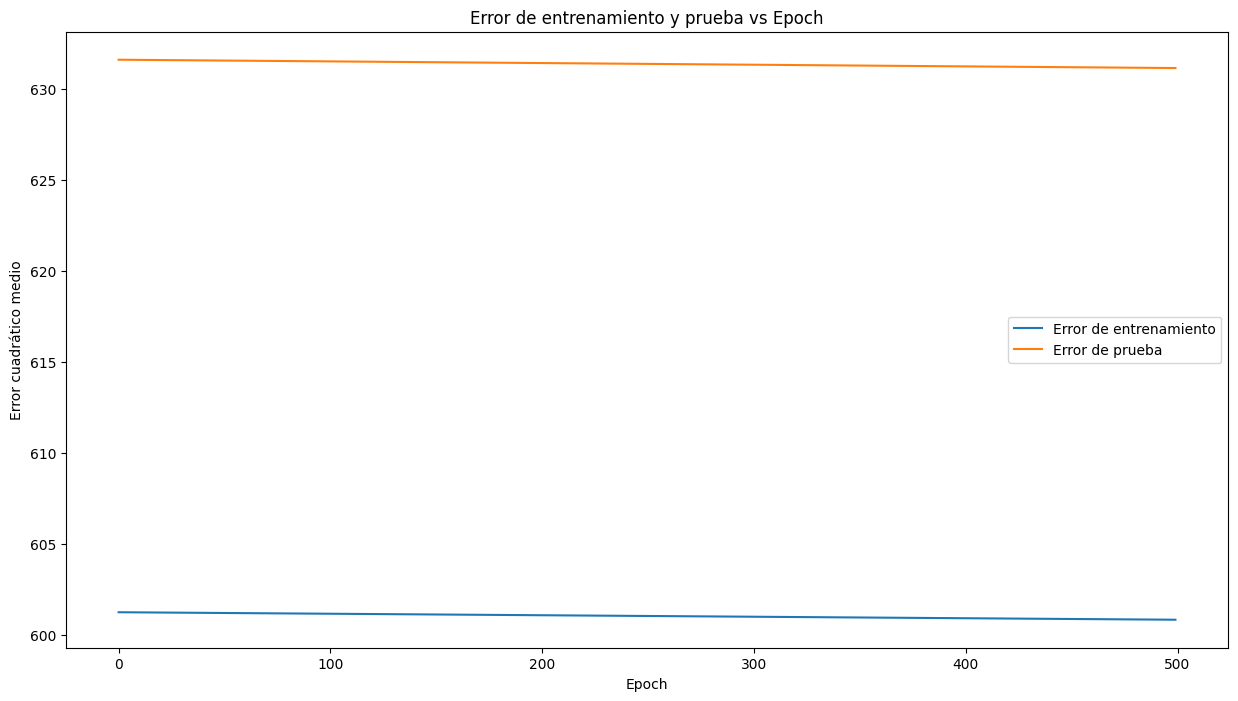

{'Train Error': 601.0629120797213,
 'Test Error': 631.3769365799018,
 'R^2': -6.59124269219655}

In [147]:
gradiente_descendente(X_train, y_train, X_test, y_test, lr=0.000000001, epochs=500)

Learning rate muy alto: Salta de un lado a otro en el espacio de soluciones sin llegar a un mínimo óptimo.

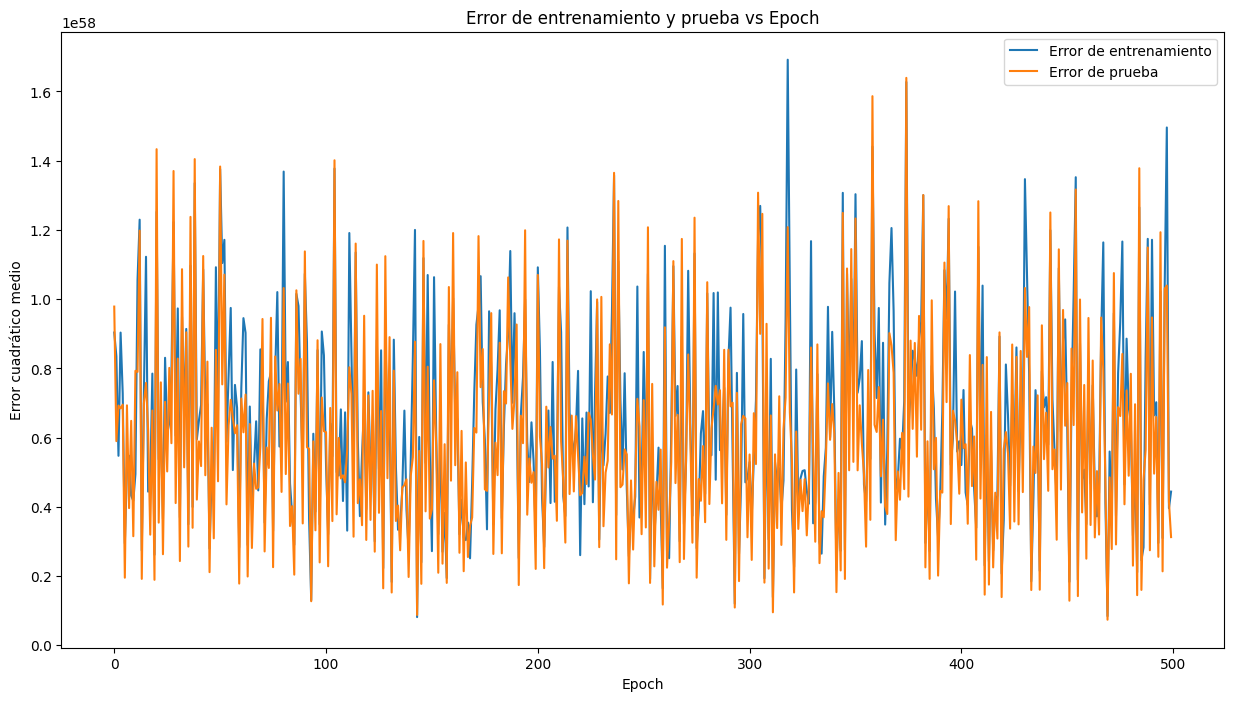

{'Train Error': 6.547539638273094e+57,
 'Test Error': 6.0118255348875826e+57,
 'R^2': -7.228206165668283e+55}

In [148]:
gradiente_descendente(X_train, y_train, X_test, y_test, lr=10**16, epochs=500)

Learning rate normal: Convergencia hacia un mínimo global.

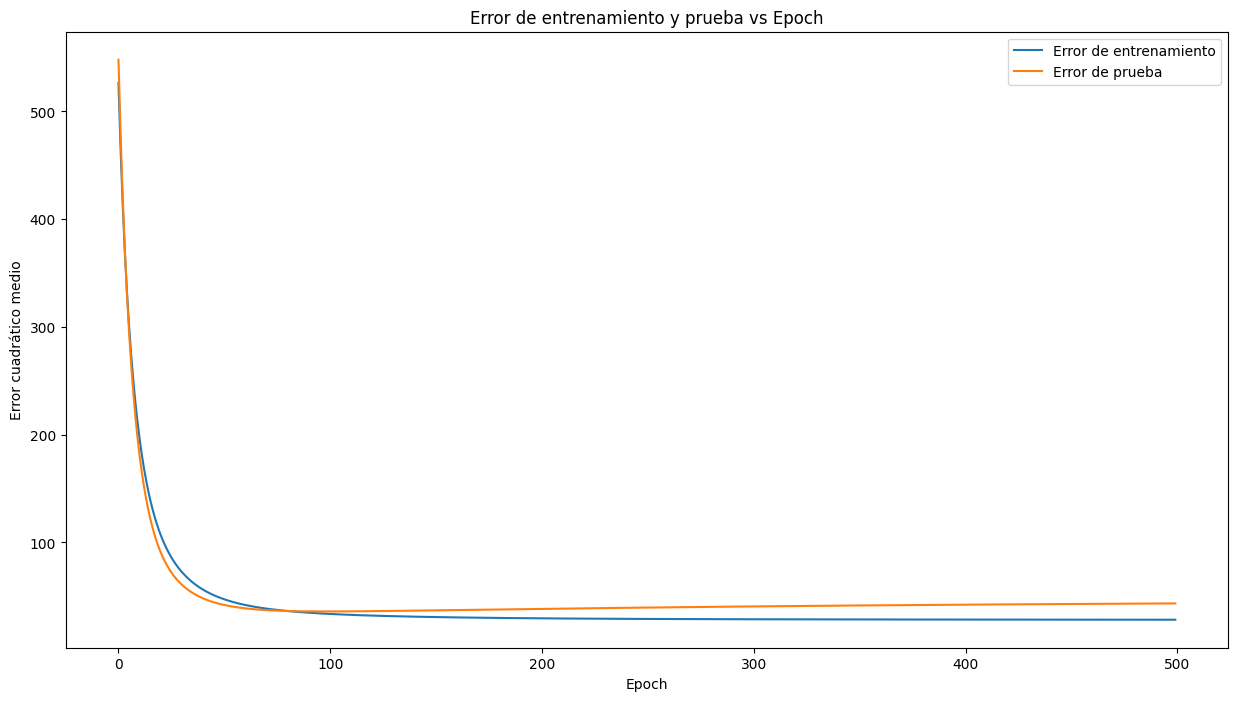

{'Train Error': 41.01558181385019,
 'Test Error': 48.734427931821216,
 'R^2': 0.4140507065401828}

In [149]:
gradiente_descendente(X_train, y_train, X_test, y_test, lr=0.0001, epochs=500)

### Mini-Batch

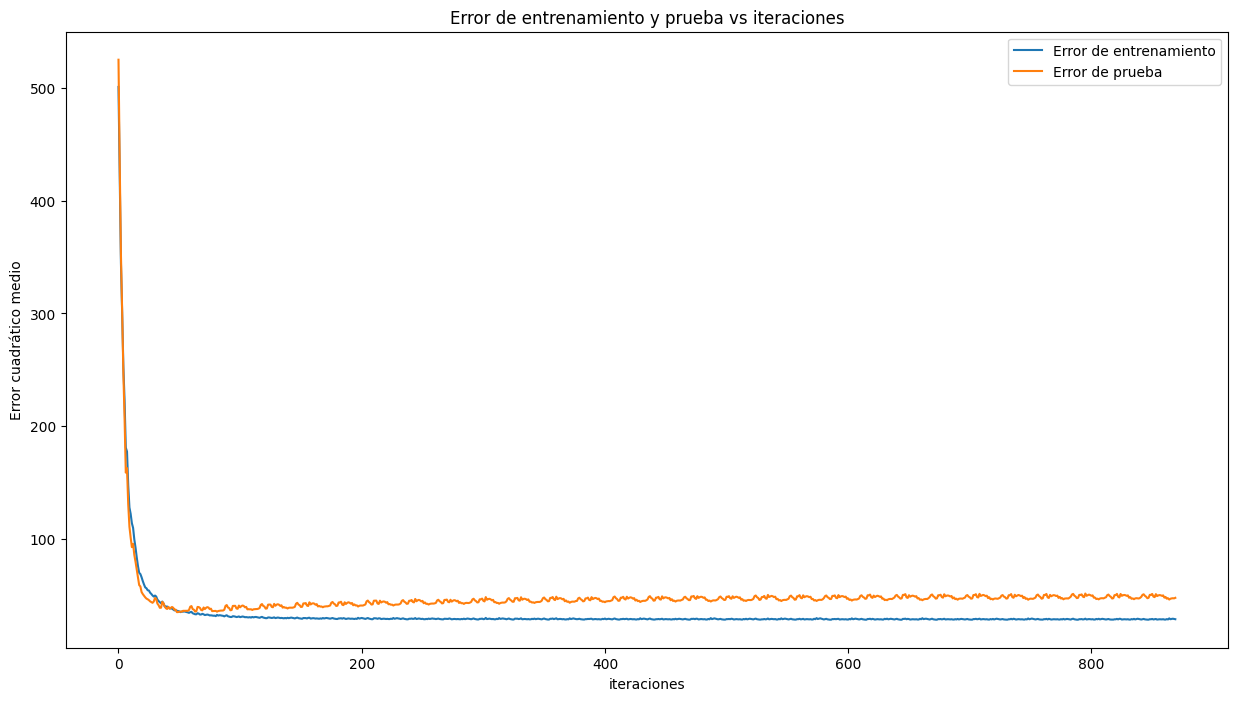

{'Train Error': 33.005238586879244,
 'Test Error': 48.158704787242314,
 'R^2': 0.42097280625717154}

In [150]:
batch = int(np.sqrt(len(X_train)))
mini_batch(X_train, y_train, X_test, y_test, lr=0.005, epochs=30, batch_size=15)

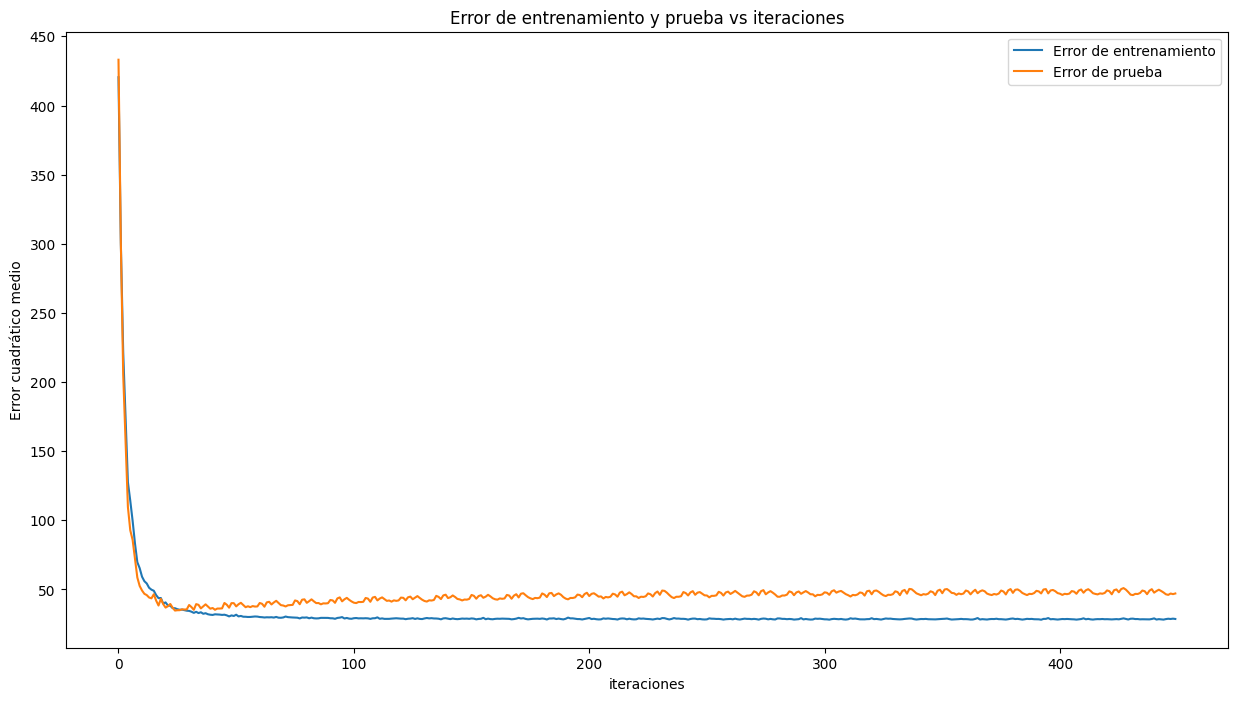

{'Train Error': 32.64837316454109,
 'Test Error': 47.446752079474706,
 'R^2': 0.4295328366873398}

In [151]:
mini_batch(X_train, y_train, X_test, y_test, lr=0.005, epochs=30, batch_size=30)

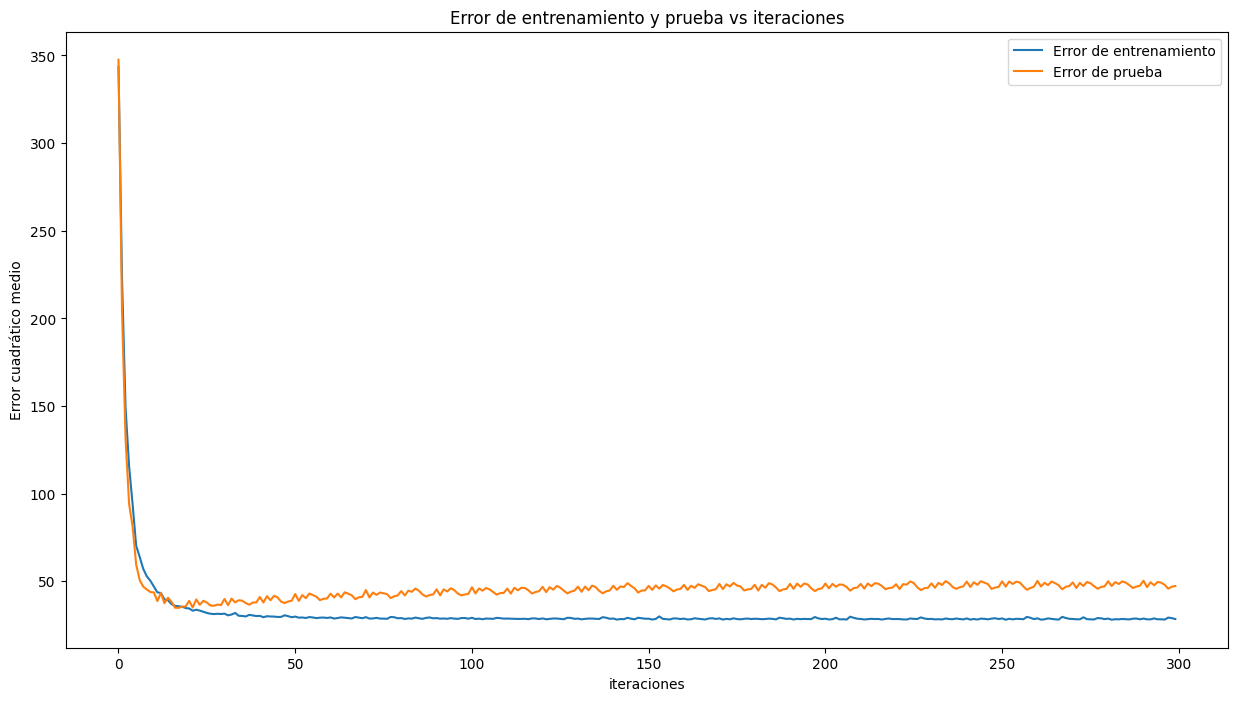

{'Train Error': 32.417969487007696,
 'Test Error': 47.131640714353104,
 'R^2': 0.433321519341263}

In [152]:
mini_batch(X_train, y_train, X_test, y_test, lr=0.005, epochs=30, batch_size=45)

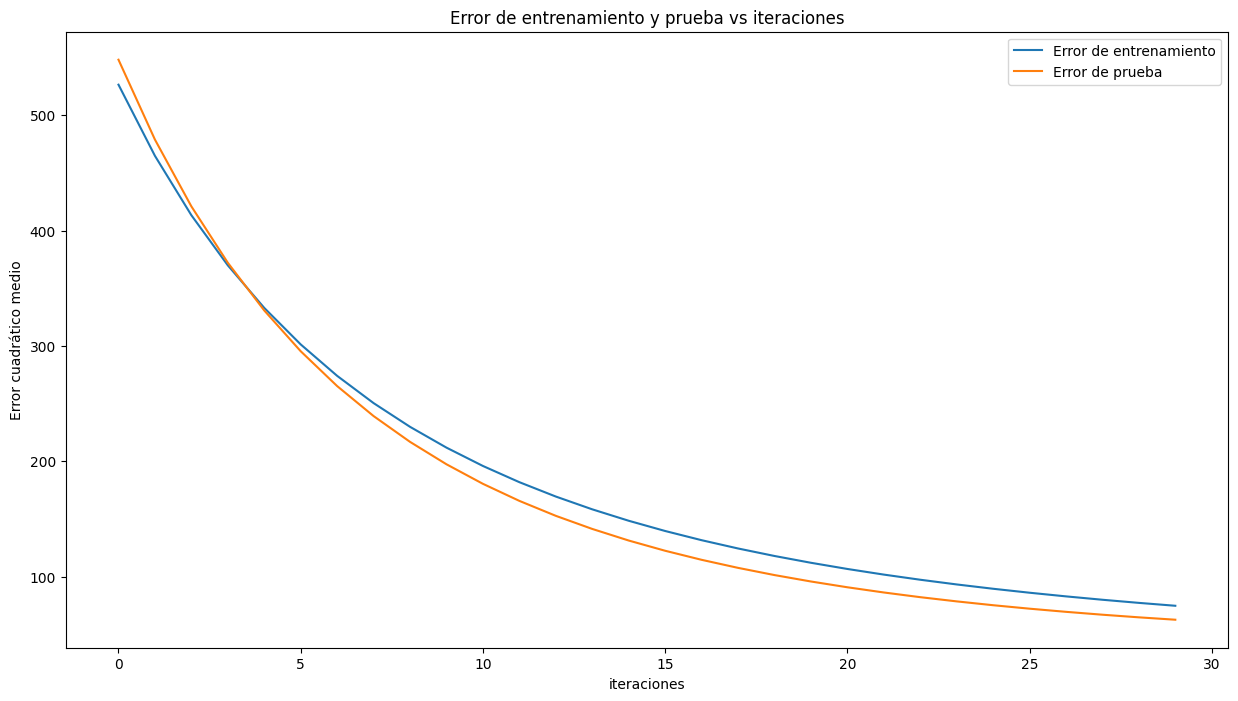

{'Train Error': 191.44318179359098,
 'Test Error': 180.8883215413925,
 'R^2': -1.1748769545544195}

In [153]:
#Batch único
mini_batch(X_train, y_train, X_test, y_test, lr=0.0001, epochs=30, batch_size=len(X_train))

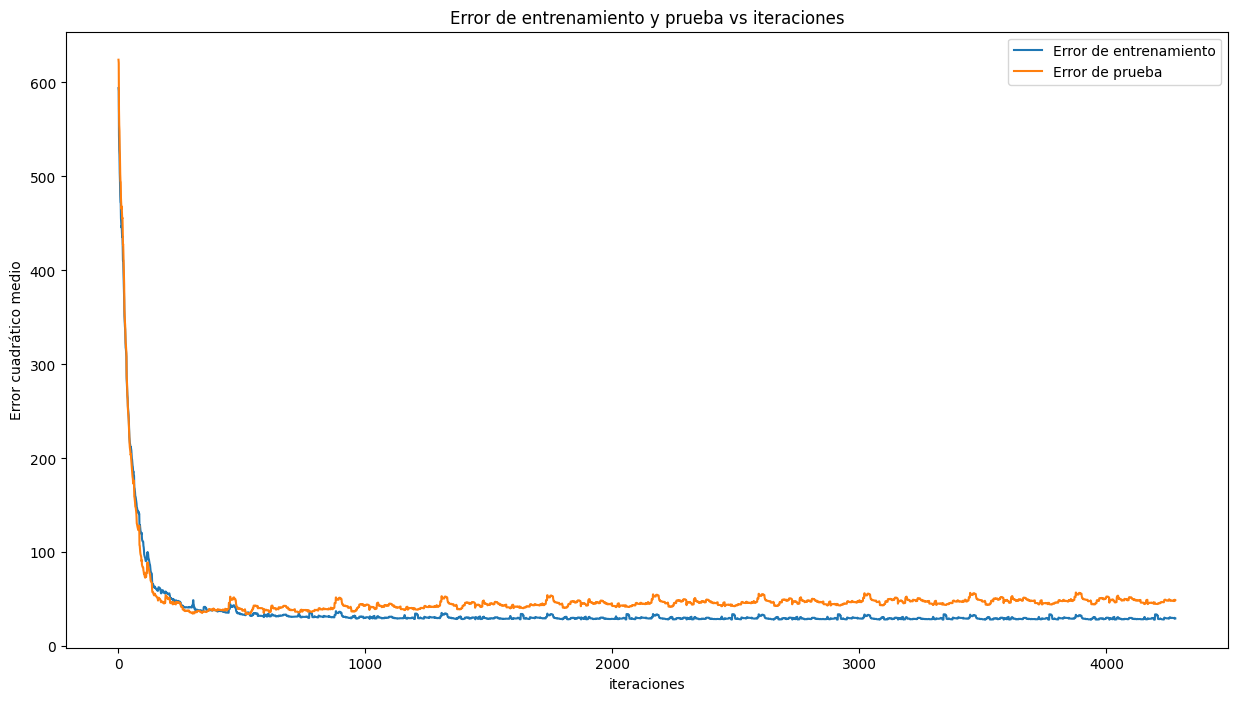

{'Train Error': 37.41236149947382,
 'Test Error': 50.75928329459984,
 'R^2': 0.3897052362119314}

In [154]:
#batch_size=1 es equivalente a no utilizar mini-batch
mini_batch(X_train, y_train, X_test, y_test, lr=0.01, epochs=10, batch_size=1)

# Conclusión

En resumen, tras evaluar diversos modelos de regresión regularizada y realizar ajustes en los hiperparámetros, los resultados obtenidos indican que el desempeño de los modelos sigue siendo limitado. Aunque algunos modelos mejoraron ligeramente, su capacidad para explicar la variabilidad de los precios de viviendas es insuficiente.

Esto sugiere que los modelos utilizados no son lo suficientemente precisos para el problema en cuestión: para mejorar el rendimiento, sería necesario explorar enfoques adicionales.